# GPU-Accelerated Molecular Clustering with nvMolKit

**Note**: This is a guest post written by Kevin Boyd at NVIDIA.

[nvMolKit](https://github.com/nvidia-digital-bio/nvMolKit) is an open-source library that provides GPU-accelerated implementations of common RDKit cheminformatics operations. The APIs closely mirror RDKit's, with batching as needed for GPU efficiency, making it easy to drop nvMolKit into existing workflows while achieving significant speedups on large datasets.

As of January 2026, nvMolKit v0.3 supports:
- Batch Morgan fingerprint calculation
- Many to many Tanimoto and Cosine similarity calculations
- Butina clustering
- Batch ETKDG conformer generation
- Batch MMFF force field optimization

In this post, we'll demonstrate nvMolKit's capabilities through a molecular clustering workflow. We'll compute Morgan fingerprints, calculate pairwise Tanimoto similarities, and perform Butina clustering, with both the RDKit and nvMolKit APIs.


## Installation

nvMolKit is available on conda-forge alongside RDKit. nvMolKit requires an NVIDIA GPU with compute capability 7.0 (V100) or higher. Some nvMolKit results are on the GPU, a CUDA-compatible torch installation can be used to interpret results.


In [1]:
!conda install -c conda-forge rdkit nvmolkit -y -q


Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

# All requested packages already installed.



In [10]:
import numpy as np
import torch
assert torch.cuda.is_available(), "CUDA is required for nvMolKit"


## Configuration

We'll process 20,000 molecules from Enamine REAL for this comparison.


In [25]:
# Number of molecules to process
n_mols = 20000

# CPU threads for multithreaded RDKit operations
n_cpu_threads = 16

# Morgan fingerprint parameters
fp_radius = 3
fp_nbits = 1024

# Butina clustering threshold
distance_threshold = 0.6


## Loading Molecules

First, we'll parse molecules from SMILES using RDKit. We'll take the first molecules from the [Enamine Real 10.4M sample](https://enamine.net/compound-collections/real-compounds/real-database-subsets)


In [24]:
import pandas as pd
from rdkit.Chem import MolFromSmiles

smi_file = "enamine_real_10M.csxmiles"

smis = pd.read_csv(smi_file, nrows=n_mols, usecols=[0], sep='\t').iloc[:, 0].to_list()
mols = [MolFromSmiles(smi) for smi in smis]
mols = [mol for mol in mols if mol]  # Remove any parse failures
n_mols = len(mols)
print(f"Parsed {n_mols} molecules")


Parsed 20000 molecules


## Workflow Description

This example workflow consists of 3 steps:
1. **Fingerprinting**: Generate Morgan fingerprints 
2. **Similarity**: Compute pairwise Tanimoto distances 
3. **Clustering**: Run Butina algorithm on the distance matrix


## RDKit Workflow


In [20]:
import time
from rdkit.Chem import rdFingerprintGenerator
from rdkit.DataStructs import BulkTanimotoSimilarity
from rdkit.ML.Cluster.Butina import ClusterData

# Step 1: Fingerprinting
t_start = time.time()
generator = rdFingerprintGenerator.GetMorganGenerator(radius=fp_radius, fpSize=fp_nbits)
fps = generator.GetFingerprints(mols, numThreads=n_cpu_threads)
t_fp = time.time() - t_start
print(f"Fingerprinting: {t_fp:.2f}s")

# Step 2: Pairwise Tanimoto distances
t_start = time.time()
distances = []
for i in range(len(mols)):
    distances.extend(BulkTanimotoSimilarity(fps[i], fps[:i], returnDistance=True))
t_sim = time.time() - t_start
print(f"Similarity matrix: {t_sim:.2f}s")

# Step 3: Butina clustering
t_start = time.time()
rdkit_clusters = ClusterData(
    np.array(distances),
    n_mols,
    distance_threshold,
    isDistData=True,
    distFunc=None,
    reordering=True
)
t_clust = time.time() - t_start
print(f"Butina clustering: {t_clust:.2f}s")

rdkit_total_time = t_fp + t_sim + t_clust
print(f"\nTotal RDKit time: {rdkit_total_time:.2f}s")


Fingerprinting: 0.04s
Similarity matrix: 11.17s
Butina clustering: 7.65s

Total RDKit time: 18.85s


## nvMolKit Workflow
Note that we add synchronizes to delimit individual timings, but the entire workflow can be run asynchronously with a single sync at the end

In [21]:
from nvmolkit.fingerprints import MorganFingerprintGenerator
from nvmolkit.similarity import crossTanimotoSimilarity
from nvmolkit.clustering import butina

# Step 1: Fingerprinting
t_start = time.time()
nvmolkit_fpgen = MorganFingerprintGenerator(radius=fp_radius, fpSize=fp_nbits)
nvmolkit_fps = nvmolkit_fpgen.GetFingerprints(mols, num_threads=n_cpu_threads)
torch.cuda.synchronize()
t_fp_nv = time.time() - t_start
print(f"Fingerprinting: {t_fp_nv:.2f}s")

# Step 2: Pairwise Tanimoto similarity -> distances
t_start = time.time()
nvmolkit_similarities = crossTanimotoSimilarity(nvmolkit_fps)
torch.cuda.synchronize()
t_sim_nv = time.time() - t_start
print(f"Similarity matrix: {t_sim_nv:.2f}s")

# Step 3: Butina clustering
t_start = time.time()
nvmolkit_distances = 1.0 - nvmolkit_similarities.torch()
cluster_ids = butina(nvmolkit_distances, distance_threshold).torch()
torch.cuda.synchronize()
t_clust_nv = time.time() - t_start
print(f"Butina clustering: {t_clust_nv:.2f}s")

nvmolkit_total_time = t_fp_nv + t_sim_nv + t_clust_nv
print(f"\nTotal nvMolKit time: {nvmolkit_total_time:.2f}s")



Fingerprinting: 0.05s
Similarity matrix: 0.02s
Butina clustering: 0.02s

Total nvMolKit time: 0.09s


## Performance Comparison - RTX 5080 GPU vs Ryzen 9 9950X

Let's visualize the speedup for each step of the workflow.

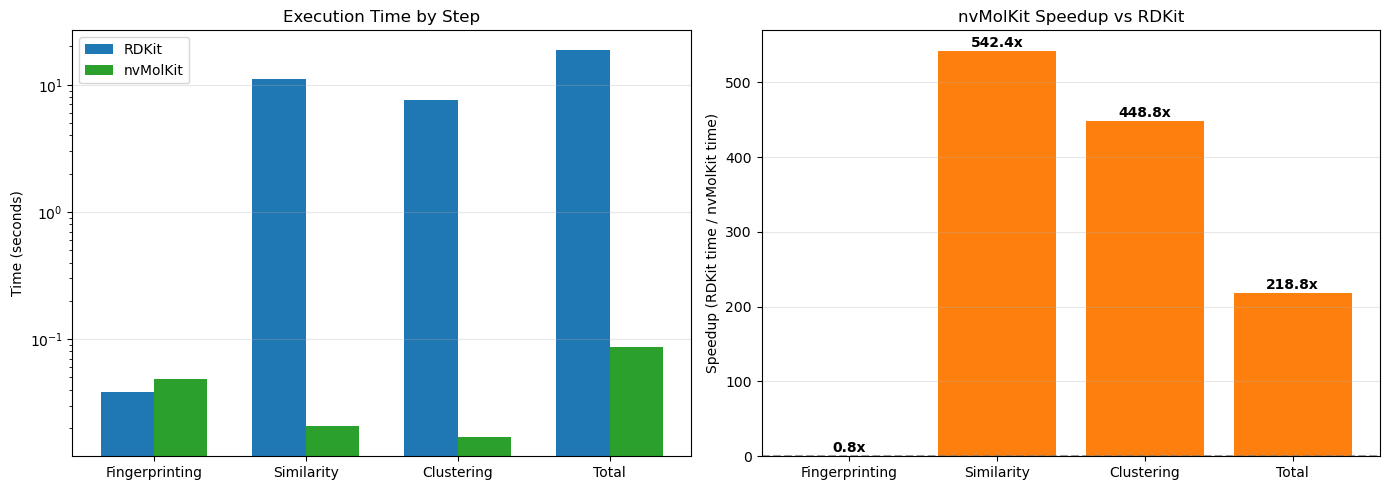


Overall speedup: 218.8x


In [22]:
import matplotlib.pyplot as plt
import numpy as np

steps = ['Fingerprinting', 'Similarity', 'Clustering', 'Total']
rdkit_times = [t_fp, t_sim, t_clust, rdkit_total_time]
nvmolkit_times = [t_fp_nv, t_sim_nv, t_clust_nv, nvmolkit_total_time]

x = np.arange(len(steps))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Time comparison
bars1 = ax1.bar(x - width/2, rdkit_times, width, label='RDKit', color='#1f77b4')
bars2 = ax1.bar(x + width/2, nvmolkit_times, width, label='nvMolKit', color='#2ca02c')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Execution Time by Step')
ax1.set_xticks(x)
ax1.set_xticklabels(steps)
ax1.legend()
ax1.set_yscale('log')
ax1.grid(axis='y', alpha=0.3)

# Speedup
speedups = [r/n for r, n in zip(rdkit_times, nvmolkit_times)]
colors = ['#ff7f0e' if s > 1 else '#d62728' for s in speedups]
bars3 = ax2.bar(steps, speedups, color=colors)
ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.7)
ax2.set_ylabel('Speedup (RDKit time / nvMolKit time)')
ax2.set_title('nvMolKit Speedup vs RDKit')
ax2.grid(axis='y', alpha=0.3)

# Add speedup labels
for bar, speedup in zip(bars3, speedups):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{speedup:.1f}x', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nOverall speedup: {rdkit_total_time / nvmolkit_total_time:.1f}x")

RDKit fingerprinting benefits from being the lowest compute workload and from native RDKit multithreading. On this hardware, the performance is about equivalent. We get large speedups from putting similarity and clustering on the GPU. On NVIDIA datacenter GPUs, speedups can be well over 1000x. 

## Comparing Clustering Results

nvMolKit and RDKit clusters are guaranteed to be identical up to the first large cluster with multiple candidates (e.g., the first centroid of size N that has another candidate centroid of that size), after which the smaller clusters may not be deterministic (but are still a valid Taylor-Butina partitioning)

Number of clusters: 14164


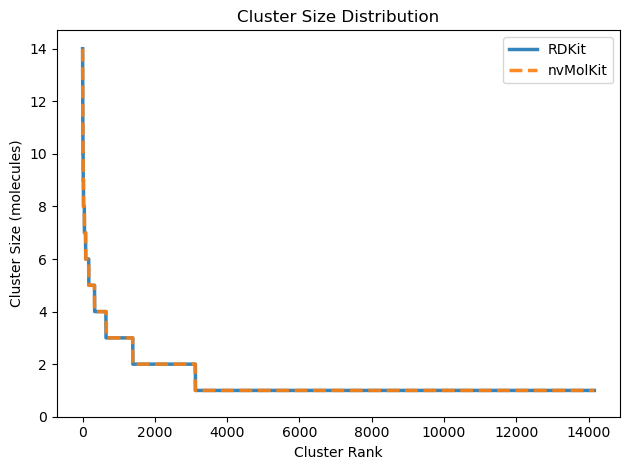

RDKit: 14162 clusters, largest has 14 molecules
nvMolKit: 14164 clusters, largest has 14 molecules


In [7]:
# Convert cluster IDs to cluster tuples for comparison
n_clusters = cluster_ids.max().item() + 1
nvmolkit_clusters = [tuple(torch.where(cluster_ids == i)[0].tolist()) for i in range(n_clusters)]
print(f"Number of clusters: {len(nvmolkit_clusters)}")

rdkit_cluster_sizes = sorted([len(c) for c in rdkit_clusters], reverse=True)
nvmolkit_cluster_sizes = sorted([len(c) for c in nvmolkit_clusters], reverse=True)

plt.figure()
plt.plot(range(len(rdkit_cluster_sizes)), rdkit_cluster_sizes, 
         label='RDKit', linewidth=2.5, alpha=0.9)
plt.plot(range(len(nvmolkit_cluster_sizes)), nvmolkit_cluster_sizes, 
         label='nvMolKit', linewidth=2.5, linestyle='--', alpha=0.9)
plt.xlabel('Cluster Rank')
plt.ylabel('Cluster Size (molecules)')
plt.title('Cluster Size Distribution')
plt.legend()
plt.ylim(0, max(rdkit_cluster_sizes) * 1.05)

plt.tight_layout()
plt.show()

print(f"RDKit: {len(rdkit_clusters)} clusters, largest has {max(rdkit_cluster_sizes)} molecules")
print(f"nvMolKit: {len(nvmolkit_clusters)} clusters, largest has {max(nvmolkit_cluster_sizes)} molecules")

## Links

For more information, see the [nvMolKit documentation](https://nvidia-digital-bio.github.io/nvMolKit/) and [GitHub repository](https://github.com/nvidia-digital-bio/nvMolKit).